## Text classification(NLP)

By using Natural Language Processing (NLP), text classifiers can automatically analyze text and then assign a set of pre-defined tags or categories based on its content.

This kernel gives a overview of performing text classification unsing Logistic Regression, Support Vector Machines and Decision tree classifier.

Here I analyzed dataset called "Economic news article tone and relevance" which consists of approximately 8000 news articles, which were tagged as relevant or not relevant to the US Economy.


In [55]:
#Import required libraries
import pandas as pd
import spacy
import re

import matplotlib.pyplot as plt
import seaborn as sn

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

## Analysis of Data

In [3]:
# Load the data set with a different encoding
df = pd.read_csv("US-Economic-News.csv", encoding='latin1')
df.shape

(8000, 15)

In [4]:
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.6400,yes,0.640,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,no,1.000,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/15 1:59,NaN,NaN,no,1.000,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,WASHINGTON -- In an effort to achieve banking ...
3,842613458,False,finalized,3,12/5/15 2:19,NaN,0.0000,no,0.675,wsj_397959018,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,NaN,NaN,The statistics on the enormous costs of employ...
4,842613459,False,finalized,3,12/5/15 17:48,3.0,0.3257,yes,0.640,wsj_398838054,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NaN,NaN,NEW YORK -- Indecision marked the dollar's ton...


In [5]:
df["relevance"].value_counts()

no          6571
yes         1420
not sure       9
Name: relevance, dtype: int64

There is an inbalance in the data set with more than 82% of data belong to not relevant category.This means that most of the articles are not relevant to US economy, which make sense in a real world scenario, as news articls discuss various topics. So kept this class imbalance as it is.

In [6]:
df = df[df.relevance != "not sure"]
df.shape

(7991, 15)

In [7]:
df["relevance"].value_counts()

no     6571
yes    1420
Name: relevance, dtype: int64

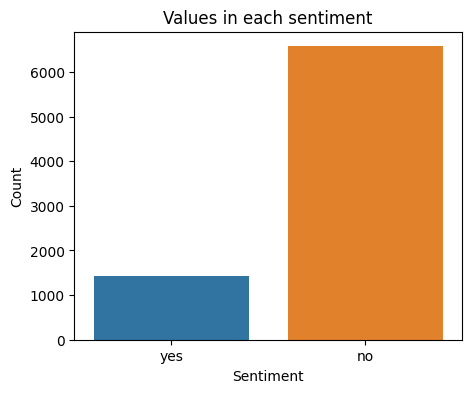

In [8]:
# Set the size of the figure
fig_size = (5,4)
plt.figure(figsize=fig_size)

# Use Seaborn for a bar plot
sns.countplot(x='relevance', data=df)

# Set plot labels and title
plt.title('Values in each sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Show the plot
plt.show()

## Text Pre-processing

In [9]:
df["relevance_num"] = df["relevance"].map({'yes' : 1, 'no': 0})
df = df[["text", "relevance_num"]]

In [10]:
df.head()

,text,relevance_num
0,NEW YORK -- Yields on most certificates of dep...,1
1,The Wall Street Journal Online</br></br>The Mo...,0
2,WASHINGTON -- In an effort to achieve banking ...,0
3,The statistics on the enormous costs of employ...,0
4,NEW YORK -- Indecision marked the dollar's ton...,1


In [11]:
df["text"][0]

'NEW YORK -- Yields on most certificates of deposit offered by major banks dropped more than a tenth of a percentage point in the latest week, reflecting the overall decline in short-term interest rates.</br></br>On small-denomination, or "consumer," CDs sold directly by banks, the average yield on six-month deposits fell to 5.49% from 5.62% in the week ended yesterday, according to an 18-bank survey by Banxquote Money Markets, a Wilmington, Del., information service.</br></br>On three-month "consumer" deposits, the average yield sank to 5.29% from 5.42% the week before, according to Banxquote. Two banks in the Banxquote survey, Citibank in New York and CoreStates in Pennsylvania, are paying less than 5% on threemonth small-denomination CDs.</br></br>Declines were somewhat smaller on five-year consumer CDs, which eased to 7.37% from 7.45%, Banxquote said.</br></br>Yields on three-month and six-month Treasury bills sold at Monday\'s auction plummeted more than a fifth of a percentage po

## Text- cleaning

Typical steps involve tokenization, lower casing, removing, stop words, punctuation markers etc, and vectorization. Other processes such as stemming/lemmatization can also be performed.

Steps :

*   removing br tags
*   punctuations
*   numbers
*   stopwords

In [12]:
nlp = spacy.load("en_core_web_sm")

def preprocess_and_vectorize(text):
  # Remove br tag
  text = re.sub(r'(?:\W*br\W)', ' ', text)
  text = re.sub(r'\[|\]', ' ', text)

  # # Tokenize and process text with SpaCy
  doc = nlp(text)

  filtered_tokens = []

  for token in doc:
      # Check for stopwords, punctuation, and numbers
      if token.is_punct or token.is_stop or token.like_num:
          continue

      # Lemmatize and convert to lowercase
      filtered_tokens.append(token.lemma_.lower())

  processed_text = " ".join(filtered_tokens)
  processed_text = re.sub(r' +', ' ', processed_text )
  processed_text

  return processed_text

In [13]:
# Example usage
text = 'Your [Text] with <br> tags goes 567 here.</br></br>'
result = preprocess_and_vectorize(text)
print(result)

 text tag go 


In [15]:
df["text"][0]

'NEW YORK -- Yields on most certificates of deposit offered by major banks dropped more than a tenth of a percentage point in the latest week, reflecting the overall decline in short-term interest rates.</br></br>On small-denomination, or "consumer," CDs sold directly by banks, the average yield on six-month deposits fell to 5.49% from 5.62% in the week ended yesterday, according to an 18-bank survey by Banxquote Money Markets, a Wilmington, Del., information service.</br></br>On three-month "consumer" deposits, the average yield sank to 5.29% from 5.42% the week before, according to Banxquote. Two banks in the Banxquote survey, Citibank in New York and CoreStates in Pennsylvania, are paying less than 5% on threemonth small-denomination CDs.</br></br>Declines were somewhat smaller on five-year consumer CDs, which eased to 7.37% from 7.45%, Banxquote said.</br></br>Yields on three-month and six-month Treasury bills sold at Monday\'s auction plummeted more than a fifth of a percentage po

In [14]:
preprocess_and_vectorize(df["text"][0])

'new york yield certificate deposit offer major bank drop percentage point late week reflect overall decline short term interest rate small denomination consumer cd sell directly bank average yield month deposit fall week end yesterday accord bank survey banxquote money markets wilmington del. information service month consumer deposit average yield sink week accord banxquote bank banxquote survey citibank new york corestates pennsylvania pay threemonth small denomination cd declines somewhat small year consumer cd ease banxquote say yield month month treasury bill sell monday auction plummet percentage point previous week respectively'

In [16]:
df["text"] = df["text"].map(preprocess_and_vectorize)

In [17]:
df["text"][1000]

'santa clara calif. george bush play need radical step cut $ federal budget deficit election argue steady control steady restraint correct republican presidential nominee insist consider deficit reduction important steady prescription suggest attach urgency assemble big deficit reduction package lawmaker business executive suggest short term worry deficit ease long economy grow push government revenue large economic growth reasonable stay project reduction target federal deficit mr. bush say interview word make lot money owe little money mr. bush dismissive national economic commission bipartisan panel study way attack deficit business political leader commission provide political cover necessary new president deal effectively deficit problem conservative worry commission member recommend tax boost deficit cut package message simple delighted willing suggestion listen american people mr. bush say commission member elect congressman president'

In [18]:
df.head()

,text,relevance_num
0,new york yield certificate deposit offer major...,1
1,wall street journal online morning brief look ...,0
2,washington effort achieve banking reform senat...,0
3,statistic enormous cost employee drug abuse kn...,0
4,new york indecision mark dollar tone trader pa...,1


Now we are ready for the modeling. We are going to use algorithms from sklearn package. We will go through the following steps:

Split the data into training and test sets (80% train, 20% test)
Extract features from the training data using TfidfVectorizer.
Transform the test data into the same feature vector as the training data.
Train the classifier
Evaluate the classifier

Train-Test split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    df.text,
    df.relevance_num,
    test_size = 0.2,
    random_state = 42,
    stratify = df.relevance_num
)

In [20]:
print("shape of X_train : ", X_train.shape, "  shape of y_train : ", y_train.shape)
print("shape of X_test : ", X_test.shape, "  shape of y_test : ", y_test.shape)

shape of X_train :  (6392,)   shape of y_train :  (6392,)
shape of X_test :  (1599,)   shape of y_test :  (1599,)


In [21]:
y_train.value_counts()

0    5256
1    1136
Name: relevance_num, dtype: int64

K Nearest Neighbors Classifier

In [46]:
clf = Pipeline([
    ("vectorizer_tfidf", TfidfVectorizer()),
    ("KNN", KNeighborsClassifier())
])

clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print("Training Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

print(classification_report(y_test, y_pred_test))

Training Accuracy score: 0.8559136420525657
Testing Accuracy score: 0.7898686679174484
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1302
           1       0.38      0.21      0.27       297

    accuracy                           0.79      1599
   macro avg       0.61      0.57      0.57      1599
weighted avg       0.75      0.79      0.76      1599



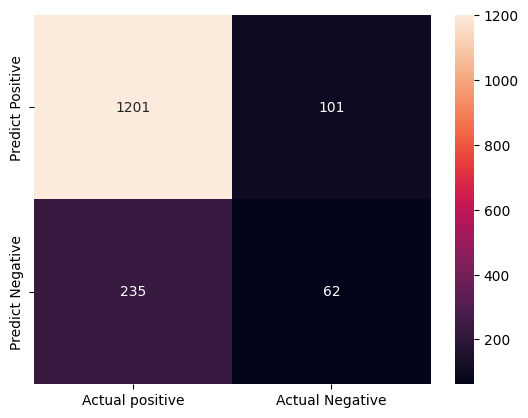

<Figure size 200x200 with 0 Axes>

In [47]:
cm = confusion_matrix(y_test, y_pred_test)

cm_matrix = pd.DataFrame(data = cm, columns = ["Actual positive", "Actual Negative"],
                         index = ["Predict Positive", "Predict Negative"])
sns.heatmap(cm_matrix, annot = True, fmt = 'd')
plt.figure(figsize=(2,2))
plt.show()


Logistic Regression

In [48]:
clf = Pipeline([
    ("vectorizer_tfidf", TfidfVectorizer()),
    ("Logistic Regression", LogisticRegression())
])

clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print("Training Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

print(classification_report(y_test, y_pred_test))


Training Accuracy score: 0.8487171464330413
Testing Accuracy score: 0.8198874296435272
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      1302
           1       0.60      0.09      0.16       297

    accuracy                           0.82      1599
   macro avg       0.71      0.54      0.53      1599
weighted avg       0.78      0.82      0.76      1599



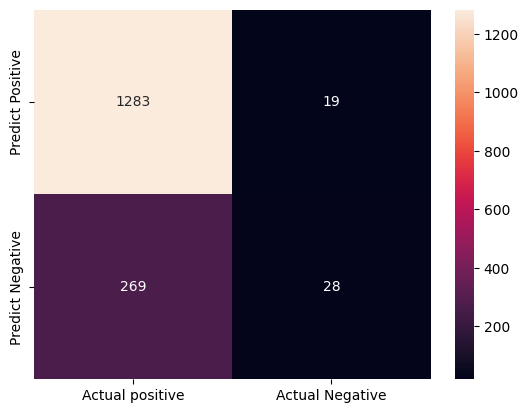

In [49]:
cm = confusion_matrix(y_test, y_pred_test)

cm_matrix = pd.DataFrame(data = cm, columns = ["Actual positive", "Actual Negative"],
                         index = ["Predict Positive", "Predict Negative"])
sns.heatmap(cm_matrix, annot = True, fmt = 'd')
plt.show()


Decision Tree Classifier

In [50]:
clf = Pipeline([
    ("vectorizer_tfidf", TfidfVectorizer()),
    ("Decision Tree Classifier", DecisionTreeClassifier())
])

clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print("Training Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

print(classification_report(y_test, y_pred_test))


Training Accuracy score: 1.0
Testing Accuracy score: 0.7454659161976235
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1302
           1       0.30      0.27      0.28       297

    accuracy                           0.75      1599
   macro avg       0.57      0.56      0.56      1599
weighted avg       0.74      0.75      0.74      1599



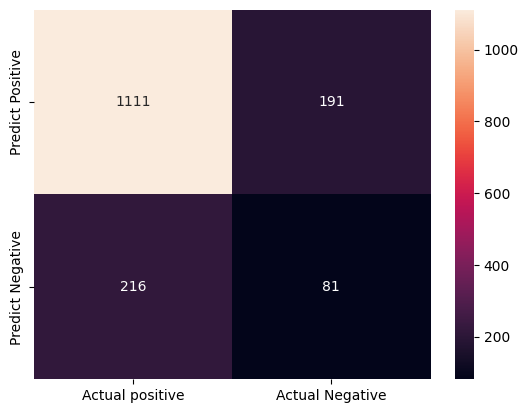

In [51]:
cm = confusion_matrix(y_test, y_pred_test)

cm_matrix = pd.DataFrame(data = cm, columns = ["Actual positive", "Actual Negative"],
                         index = ["Predict Positive", "Predict Negative"])
sns.heatmap(cm_matrix, annot = True, fmt = 'd')
plt.show()


Support Vector Machines

In [52]:
clf = Pipeline([
    ("vectorizer_tfidf", TfidfVectorizer()),
    ("Support vector machines", LinearSVC())
])

clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print("Training Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

print(classification_report(y_test, y_pred_test))


Training Accuracy score: 0.9740300375469336
Testing Accuracy score: 0.8061288305190745
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      1302
           1       0.44      0.17      0.25       297

    accuracy                           0.81      1599
   macro avg       0.64      0.56      0.57      1599
weighted avg       0.76      0.81      0.77      1599



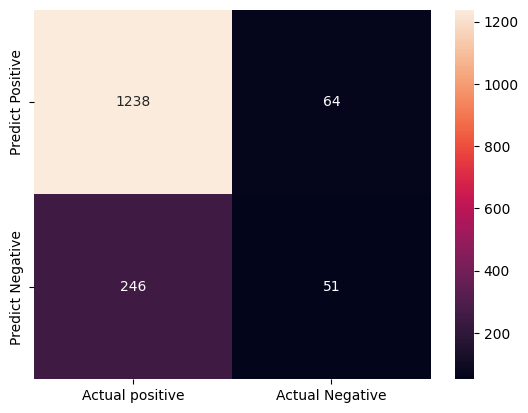

In [53]:
cm = confusion_matrix(y_test, y_pred_test)

cm_matrix = pd.DataFrame(data = cm, columns = ["Actual positive", "Actual Negative"],
                         index = ["Predict Positive", "Predict Negative"])
sns.heatmap(cm_matrix, annot = True, fmt = 'd')
plt.show()
